# A/B Testing

A/B testing, also known as split testing or bucket testing, is a powerful method for comparing two versions of a variable to determine which one performs better in terms of a given metric. This technique is widely used in various fields, including marketing, product development, and website optimization, to make data-driven decisions. In this tutorial, we'll explore the basics of A/B testing, illustrate a simple example, and delve into more advanced topics, such as network effects and complex statistical considerations.

## A simple example

Consider a scenario in the electricity market where we want to compare the effectiveness of two different marketing campaigns aimed at encouraging customers to use more renewable energy. We'll define two groups:

- **Group A (Control Group)**: Receives the standard marketing message.
- **Group B (Treatment Group)**: Receives a new, enhanced marketing message.

The goal is to determine which marketing message results in higher usage of renewable energy.

**Step-by-Step Procedure:**

1. **Random assignment**: randomly assign customers to either Group A or Group B to ensure that each group is representative of the overall population.

2. **Implementation**: send the standard marketing message to Group A, and the enhanced marketing message to Group B.

3. **Measurement**: after a predetermined period, measure the amount of renewable energy used by customers in both groups.

4. **Analysis**: compare the average renewable energy usage between the two groups using statistical tests, such as a t-test, to determine if the difference is statistically significant.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

# Simulate data
np.random.seed(42)
group_a = np.random.normal(loc=50, scale=10, size=100)  # Control group
group_b = np.random.normal(loc=55, scale=10, size=100)  # Treatment group

# Perform t-test
t_stat, p_value = stats.ttest_ind(group_b, group_a)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("The enhanced marketing message significantly increases renewable energy usage.")
else:
    print("There is no significant difference between the two marketing messages.")

T-statistic: 4.7546959435052765
P-value: 3.8191352626795345e-06
The enhanced marketing message significantly increases renewable energy usage.


## Statistical considerations 

A/B testing involves several statistical concepts to ensure valid and reliable results:

1. **Power analysis**: determine the sample size needed to detect a significant effect.
2. **Multiple testing**: adjust for the increased likelihood of Type I errors when conducting multiple comparisons (e.g., using Bonferroni correction).
3. **Heterogeneous treatment effects**: explore how treatment effects vary across different subgroups.


For example, power analysis helps in calculating the sample size required to achieve a desired power level, given an effect size and significance level (alpha).

In [2]:
from statsmodels.stats.power import TTestIndPower

# Parameters
effect_size = 0.5
alpha = 0.05
power = 0.8

# Calculate required sample size
analysis = TTestIndPower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power, alternative='two-sided')
print(f"Required sample size per group: {int(sample_size)}")

Required sample size per group: 63


The code performs a power analysis to determine the minimum sample size required for each group in an A/B test, given an expected effect size, significance level, and desired power. This ensures that the test is adequately powered to detect a meaningful effect, reducing the risk of Type I and Type II errors.

By conducting power analysis before running an experiment, researchers can ensure that they collect enough data to make reliable and valid conclusions, optimizing resource use and improving the quality of the results.

## Network effect

While the basic A/B testing framework is useful, it often needs to be adapted for more complex scenarios. One such scenario involves network effects, where the treatment effect on one individual may spill over to others through social connections. This is particularly relevant in social networks and interconnected systems. In traditional A/B testing, relying on the stable unit treatment value assumption (SUTVA), we assume that each individual's response is independent of others. However, in many cases, this assumption does not hold due to network effects. For instance, in a social network, a user's engagement with a new feature may influence their friends' engagement, leading to biased estimates of the treatment effect. To address this, Gui et al. {cite}`gui2015network` proposed a method for network A/B testing, considering these spillover effects.

The key aspects are:
1. **Network effects**: the influence of one user's treatment on their neighbors.
2. **Cluster randomized sampling**: partition the network into clusters and randomize at the cluster level to minimize information flow between treatment and control groups.

Mathematically, the average treatment effect (ATE) under network effects is given by:
\begin{equation}
  \delta(1, 0) = \frac{1}{N} \sum_{i=1}^{N} E[Y_i(Z = 1) - Y_i(Z = 0)]
\end{equation}

where $Y_i(Z = z)$ is the response of user \(i\) given treatment assignment $Z = z$.

In the following example, we explore how to conduct A/B testing in the presence of network effects. Network effects occur when the treatment assigned to one individual affects not only their own outcome but also the outcomes of others they are connected to. This violates the no interference assumption of SUTVA and requires special methods to account for these effects.

We will use a random graph to simulate a social network, where each node represents an individual, and edges represent connections between individuals. We'll randomly assign treatments and simulate outcomes based on these assignments and the network structure. Finally, we'll fit a linear regression model to estimate the Average Treatment Effect (ATE), considering network effects.

1. **Generate a random graph**: we use the Erdős-Rényi model to generate a random graph with 1000 nodes, where each edge is included with a probability of 0.05. The adjacency matrix $A$ represents the connections between individuals.

2. **Simulate data**: randomly assign each individual to the treatment (1) or control (0) group. Simulate the outcome $Y$ for each individual based on their own treatment and the treatments of their neighbors. The outcome also includes some random noise.

3. **Fit a linear regression model**: use a linear regression model to account for the network effects. The model includes both the individual's treatment and the sum of their neighbors' treatments as predictors. Estimate the coefficients, which include the ATE considering network effects.

4. **Visualize the Network**: plot the network to visualize the structure and treatment assignments.

Coefficients: [-0.03368653  0.99760116]
ATE considering network effects: -0.033686529505670026


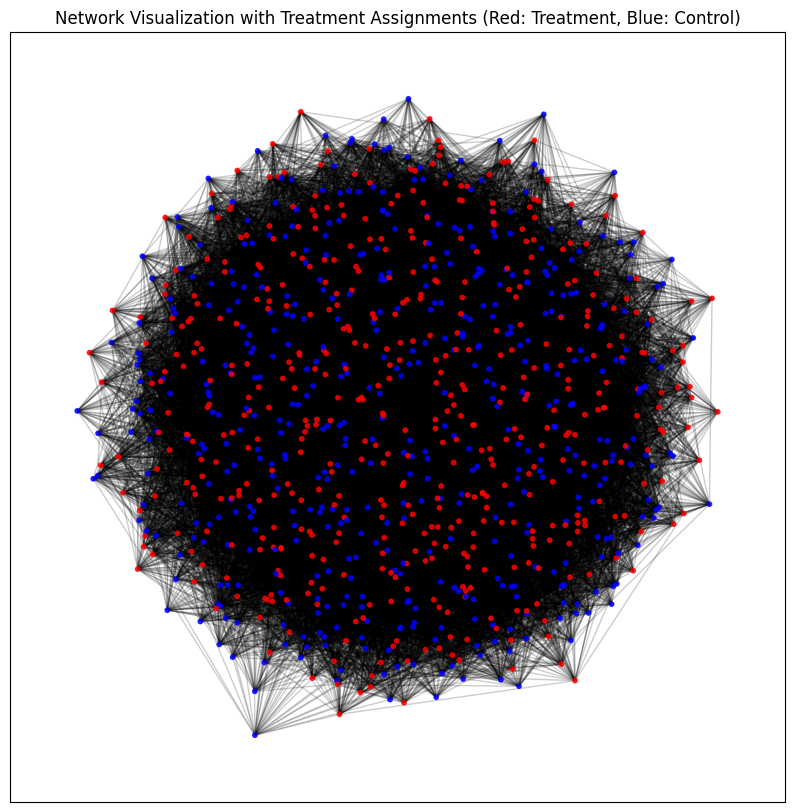

In [3]:
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Generate a random graph
G = nx.erdos_renyi_graph(n=1000, p=0.05, seed=42)
A = nx.to_numpy_array(G)

# Simulate data
np.random.seed(42)
Z = np.random.choice([0, 1], size=1000, p=[0.5, 0.5])  # Random assignment
Y = np.dot(A, Z) + np.random.normal(size=1000)  # Network effects

# Fit a linear regression model to account for network effects
X = np.column_stack([Z, np.dot(A, Z)])
model = LinearRegression().fit(X, Y)
print("Coefficients:", model.coef_)

# Calculate ATE considering network effects
ATE = model.coef_[0]
print("ATE considering network effects:", ATE)

# Visualize the network with treatment assignments
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G, seed=42)
node_color = ['red' if z == 1 else 'blue' for z in Z]
nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=10, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.2)
plt.title("Network Visualization with Treatment Assignments (Red: Treatment, Blue: Control)")
plt.show()

This example demonstrates how to account for network effects in A/B testing. By including the treatment status of an individual's neighbors as a predictor in the regression model, we can obtain a more accurate estimate of the treatment effect. This approach is particularly useful in settings where interactions between individuals play a significant role, such as social networks, epidemiology, and interconnected markets.